In [2]:

!pip install tensorflow==1.14.0

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, Input, regularizers
from keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2020-06-17 06:41:32--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  53.3MB/s    in 3.2s    

2020-06-17 06:41:35 (53.3 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [4]:
! tar -xvzf lfw.tgz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Aiken/Clay_Aiken_000

In [46]:
face_images = glob.glob('lfw/**/*.jpg')

In [47]:
all_images=[]

for i in tqdm(face_images):
  img=image.load_img(i,target_size=(80,80,3))
  img=image.img_to_array(img)
  # img=img/255
  all_images.append(img)

100%|██████████| 13233/13233 [00:16<00:00, 779.60it/s]


In [48]:
all_images=np.array(all_images)
train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.1)

In [49]:
train_x[0]

array([[[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       ...,

       [[198., 205., 198.],
        [195., 202., 195.],
        [195., 202., 195.],
        ...,
        [ 40.,  44.,  43.],
        [ 39.,  43.,  42.],
        [ 38.,  42.,  41.]],

       [[195., 202., 195.],
        [188., 195., 188.],
        [189., 196., 189.],
        ...,
        [ 40.,  44.,  43.],
        [ 39.,  43.,  42.],
        [ 37.,  41.,  40.]],

       [[203., 210., 203.],
        [189., 196., 189.],
        [193., 2

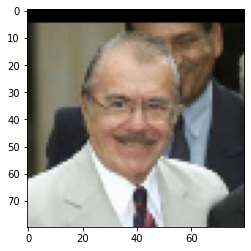

In [51]:
plt.imshow(train_x[0].astype(np.uint8))

In [52]:
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

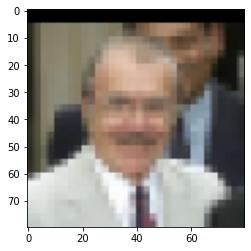

In [54]:
plt.imshow(pixalate_image(train_x[0].astype(np.uint8)))

In [55]:
#preparing dataset

In [56]:
train_x_px=[]
for i in range(train_x.shape[0]):
  temp=pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)

val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

In [85]:
Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse',metrics='accuracy')

In [86]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 80, 80, 256)       7168      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 80, 80, 128)       295040    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 40, 40, 64)        73792     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 40, 40, 64)        36928     
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 80, 80, 64)        0   

In [24]:
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
checkpoint = ModelCheckpoint("gdrive/My Drive/blurr images/my_model.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

In [60]:
a_e = autoencoder.fit(train_x_px, train_x,
            epochs=1,
            batch_size=256,

            shuffle=True,
            validation_data=(val_x_px, val_x),
   
            callbacks=[checkpoint,early]
            )

47/47 [==============================] - 177s 4s/step - loss: 4532.0029 - accuracy: 0.5050 - val_loss: 1164.2495 - val_accuracy: 0.6377


In [78]:
autoencoder.load_weights("gdrive/My Drive/blurr images/my_model.h5")

In [79]:
predictions = autoencoder.predict(val_x_px)

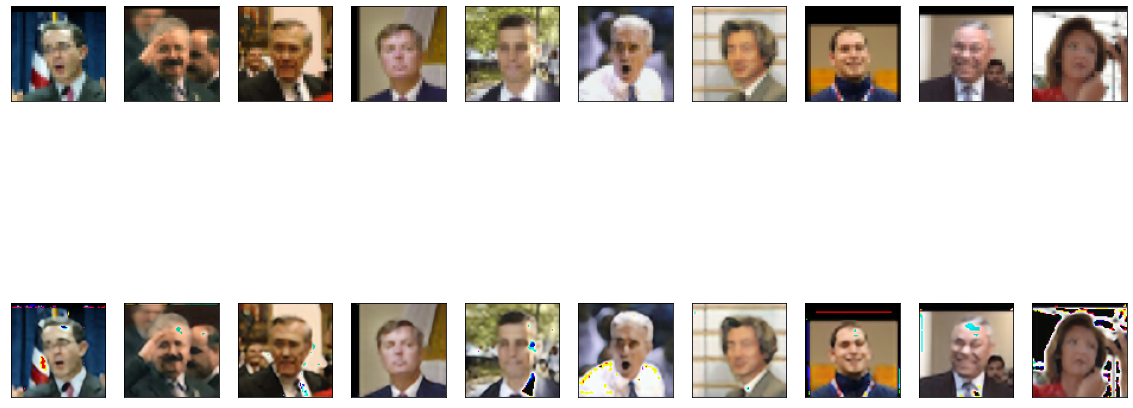

In [80]:
n = 10
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x_px[i+20].astype(np.uint8))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i+20].astype(np.uint8))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [87]:
# from tensorflow.keras.optimizers import Adam

# opt = Adam(lr=0.001)


In [88]:
# Input_img = Input(shape=(80, 80, 3))  
    
# #encoding architecture
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
# x2 = MaxPool2D( (2, 2))(x2)
# encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# # decoding architecture
# x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
# decoded = Conv2D(3, (3, 3), padding='same')(x1)


# autoencoder = Model(Input_img, decoded)
# autoencoder.compile(optimizer=opt, loss='mse',metrics='accuracy')

In [89]:
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
checkpoint = ModelCheckpoint("gdrive/My Drive/blurr images/my_model1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

In [90]:
a_e = autoencoder.fit(train_x_px, train_x,
            epochs=50,
            batch_size=256,

            shuffle=True,
            validation_data=(val_x_px, val_x),
   
            callbacks=[checkpoint,early]
            )

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 8309.1660 - accuracy: 0.5507
Epoch 00001: val_loss improved from inf to 1076.99316, saving model to gdrive/My Drive/blurr images/my_model1.h5
47/47 [==============================] - 163s 3s/step - loss: 8309.1660 - accuracy: 0.5507 - val_loss: 1076.9932 - val_accuracy: 0.6161
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 663.5130 - accuracy: 0.6746
Epoch 00002: val_loss improved from 1076.99316 to 399.40421, saving model to gdrive/My Drive/blurr images/my_model1.h5
47/47 [==============================] - 163s 3s/step - loss: 663.5130 - accuracy: 0.6746 - val_loss: 399.4042 - val_accuracy: 0.7434
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 340.6562 - accuracy: 0.7738
Epoch 00003: val_loss improved from 399.40421 to 291.16803, saving model to gdrive/My Drive/blurr images/my_model1.h5
47/47 [==============================] - 164s 3s/step - loss: 340.6562 - accuracy: 0.7738 -

In [91]:
autoencoder.load_weights("gdrive/My Drive/blurr images/my_model1.h5")

In [92]:
predictions = autoencoder.predict(val_x_px)

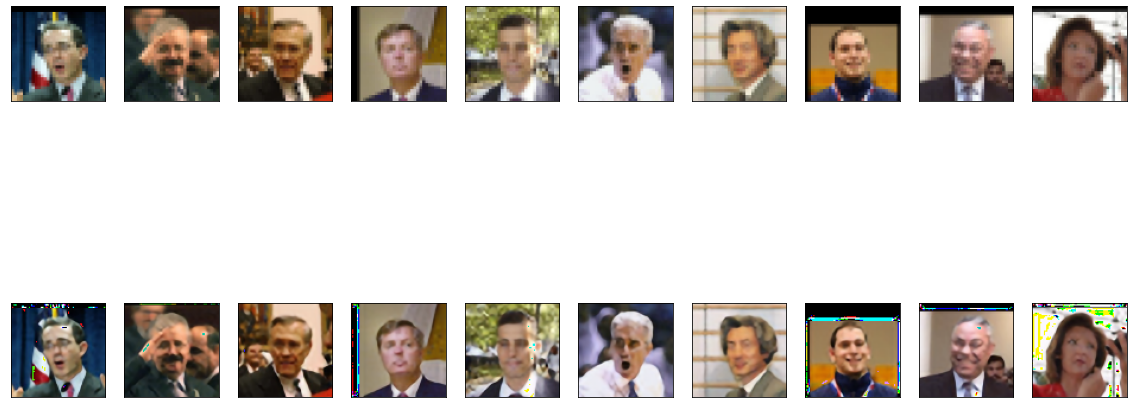

In [93]:
n = 10
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x_px[i+20].astype(np.uint8))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i+20].astype(np.uint8))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()